In [138]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # visuals 

from sklearn.preprocessing import MinMaxScaler # scale the data
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # time series Generator
from tensorflow.keras.models import Sequential # Sequential model
from tensorflow.keras.layers import Dense, LSTM, Dropout # LSTM
from tensorflow.keras.callbacks import EarlyStopping # Early Stopping
import tensorflow as tf
# load the dataset
df = pd.read_csv('sales_forcasting.csv', parse_dates = True, index_col='DATE')
dataset = df.values
dataset = dataset.astype('float32')


In [139]:
df.head()

,item_sold
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0011d66f50>],
      dtype=object)

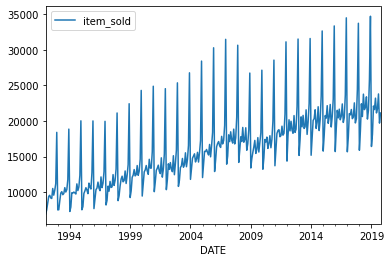

In [140]:
df.plot(subplots=True)

In [141]:
df.head()

,item_sold
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


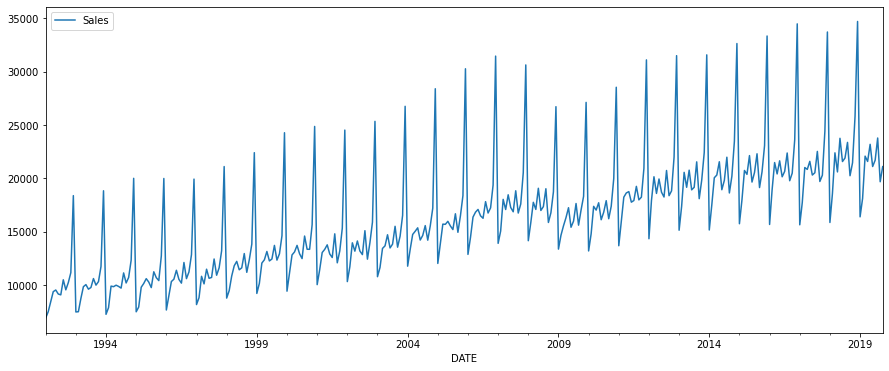

In [142]:
# scaler 
# rename the column
df.columns = ['Sales']
# plot the data 
df.plot(figsize = (15,6));

In [143]:
# rename the column
df.columns = ['Sales']

In [144]:
# train test split 
test_size = 18
test_index = len(df) - test_size 

train = df.iloc[:test_index]
test = df.iloc[test_index:]

In [145]:
train.tail()

,Sales
DATE,
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585
2018-03-01,22404
2018-04-01,20616


In [146]:
test.head()

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260


In [147]:
# scaler 
scaler = MinMaxScaler()

# fit the scaler on the training data 
scaler.fit(train)

# use the scaler to transform training and test data 
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [148]:
# Timeseries Generator
length = 12 # a whole year 
train_generator = TimeseriesGenerator(scaled_train, scaled_train, length = length, batch_size = 1)
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length = length, batch_size = 1)

In [149]:
X, y = train_generator[0]

In [150]:
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [151]:
y

array([[0.02047633]])

In [152]:
# number of features in our dataset
n_features = 1 

# build the model
model = Sequential()
model.add(LSTM(64, activation = 'relu', input_shape = (length, n_features)))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss = 'mse')

# Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=2)

# fir the model
history = model.fit(train_generator, epochs = 20, validation_data= validation_generator);

Epoch 1/20
304/304 [==============================] - 3s 7ms/step - loss: 0.0256 - val_loss: 0.0031
Epoch 2/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0201 - val_loss: 0.0060
Epoch 3/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0168 - val_loss: 0.0032
Epoch 4/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0106 - val_loss: 0.0258
Epoch 5/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0047 - val_loss: 0.0035
Epoch 6/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0040 - val_loss: 0.0026
Epoch 7/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0020 - val_loss: 8.5515e-04
Epoch 8/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 9/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0018 - val_loss: 0.0038
Epoch 10/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0014 - val_loss: 0.

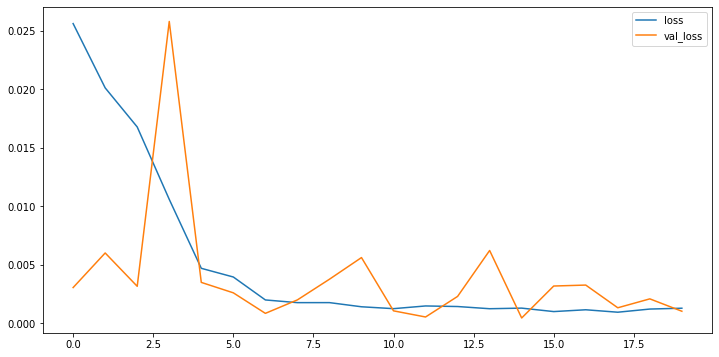

In [153]:
# plot losses 
losses = pd.DataFrame(model.history.history)
losses.plot(figsize = (12,6))

In [154]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [155]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [156]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,22081.212865
2018-06-01,21589,20884.355527
2018-07-01,21919,21068.861997
2018-08-01,23381,22889.421929
2018-09-01,20260,20351.755301
2018-10-01,21473,20972.957510
2018-11-01,25831,25119.721701
2018-12-01,34706,34994.922207
2019-01-01,16410,16508.754324


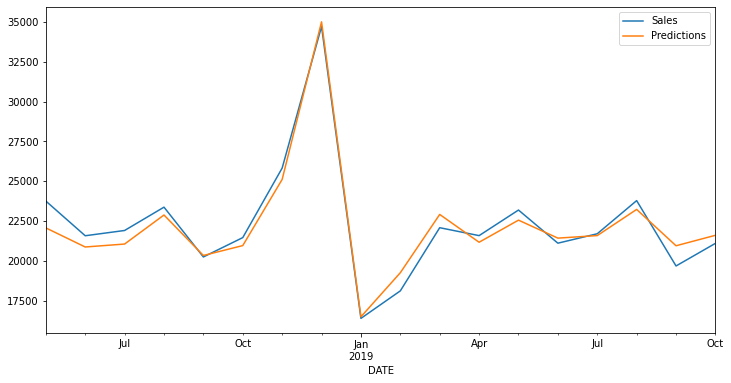

In [157]:
test.plot(figsize = (12, 6));

In [158]:
# scale the full data 
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [159]:
# generator for the full data 
length = 12
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = 1)

In [160]:
# number of features in our dataset
n_features = 1 

# build the model
model = Sequential()
model.add(LSTM(64, activation = 'relu', input_shape = (length, n_features)))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss = 'mse')

# fir the model
history = model.fit(generator, epochs = 10);

Epoch 1/10
322/322 [==============================] - 3s 6ms/step - loss: 0.0254
Epoch 2/10
322/322 [==============================] - 2s 6ms/step - loss: 0.0182
Epoch 3/10
322/322 [==============================] - 2s 6ms/step - loss: 0.0162
Epoch 4/10
322/322 [==============================] - 2s 6ms/step - loss: 0.0094
Epoch 5/10
322/322 [==============================] - 2s 6ms/step - loss: 0.0039
Epoch 6/10
322/322 [==============================] - 2s 6ms/step - loss: 0.0025
Epoch 7/10
322/322 [==============================] - 2s 6ms/step - loss: 0.0023
Epoch 8/10
322/322 [==============================] - 2s 8ms/step - loss: 0.0014
Epoch 9/10
322/322 [==============================] - 2s 7ms/step - loss: 0.0014
Epoch 10/10
322/322 [==============================] - 2s 6ms/step - loss: 0.0014


In [161]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [162]:
# true values of the forcast  
forecast = scaler.inverse_transform(forecast)

In [163]:
# create a date index 
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [164]:
# concatinate index with forcasts  
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])
forecast_df

,Forecast
2019-11-01,25484.576087
2019-12-01,34591.304454
2020-01-01,16186.422093
2020-02-01,17843.049970
2020-03-01,21405.079332
2020-04-01,20965.216657
2020-05-01,22451.176378
2020-06-01,20550.728054
2020-07-01,21146.413358
2020-08-01,23111.238817


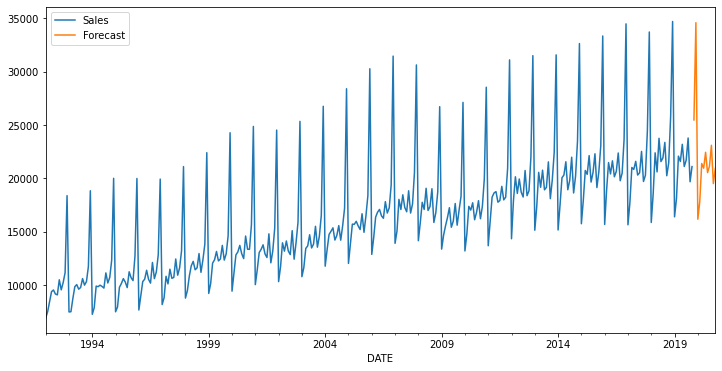

In [165]:
ax = df.plot(figsize = (12,6))
forecast_df.plot(ax = ax)

(576.0, 611.0)

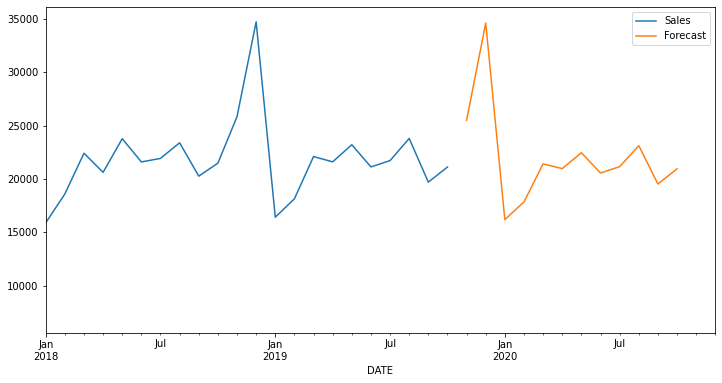

In [166]:
# zoom in
ax = df.plot(figsize = (12,6))
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')

# **Convert TFLite**

In [167]:
export_dir = 'saved_model'

# Use the tf.saved_model API to save your model in the SavedModel format
tf.saved_model.save(model, export_dir = export_dir)

INFO:tensorflow:Assets written to: saved_model/assets


In [168]:
# Select mode of optimization
mode = "Speed" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [169]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

79308

# **H5**

In [170]:
model.save('sales forcasting','/model_save_path')
model.save('trained_model.h5')
print(' Model saved ')

INFO:tensorflow:Assets written to: sales forcasting/assets


INFO:tensorflow:Assets written to: sales forcasting/assets


 Model saved 


# **History.pkl**

In [171]:
def download_history():
  import pickle
  from google.colab import files

  with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

  files.download('history.pkl')

download_history()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>